In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# aggregate + save
from loader import run
#
# set to True to rebuild training parquet files
need_to_rebuild_parquets = False
# set to 'force-refresh' to rebuild parquet files from DB
# set to 'auto' to use cached db results if they exist (TODO: implement auto cache check)
cache_mode = 'auto'
#
if need_to_rebuild_parquets:
    run(cache_mode=cache_mode)

In [71]:
# load
import pyarrow as pa
import pyarrow.parquet as pq
#
phishing = pq.read_table('floor/phishing.parquet')
benign_u = pq.read_table('floor/benign.parquet')

from transformers.drop_nontrain import drop_nontrain
phishing = drop_nontrain(phishing)
benign_u = drop_nontrain(benign_u)

# realign schemas (parquet files save in nonsense orders)
phishing_order = phishing.schema.names
benign = benign_u.select(phishing_order)

data = pa.concat_tables([phishing, benign])
df = data.to_pandas()
from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

df

,label,domain_registration_date,domain_expiration_date,domain_last_changed_date,average_rtt,has_tls,tls_chain_len,tls_version_score,tls_cipher_score,root_cert_validity_len,...,countries_count,lat_stddev,lon_stddev,dns_A_count,dns_AAAA_count,dns_CNAME_count,dns_MX_count,dns_NS_count,dns_SOA_count,dns_TXT_count
0,misp:phishing,NaN,NaN,NaN,98.4360,True,4.0,2.0,0.0,9066.0,...,1,0.0,0.0,4,0,0,0,0,0,0
1,misp:phishing,NaN,NaN,NaN,0.0000,False,NaN,NaN,NaN,NaN,...,1,0.0,0.0,1,0,0,0,0,0,0
2,misp:phishing,NaN,NaN,NaN,-1.0000,False,NaN,NaN,NaN,NaN,...,0,0.0,0.0,0,0,0,0,0,0,0
3,misp:phishing,NaN,NaN,NaN,0.0000,False,NaN,NaN,NaN,NaN,...,1,0.0,0.0,1,0,0,1,0,0,0
4,misp:phishing,NaN,NaN,NaN,0.0000,True,3.0,3.0,1.0,3583.0,...,1,0.0,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295348,benign:unknown,NaN,NaN,NaN,3.7640,True,4.0,3.0,2.0,9132.0,...,1,0.0,0.0,1,0,1,0,2,1,0
295349,benign:unknown,NaN,NaN,NaN,6.4805,True,3.0,3.0,2.0,1349.0,...,1,0.0,0.0,2,0,1,0,0,0,0
295350,benign:unknown,NaN,NaN,NaN,15.4715,True,3.0,3.0,2.0,1349.0,...,1,0.0,0.0,2,2,1,0,0,0,0
295351,benign:unknown,NaN,NaN,NaN,94.7250,True,3.0,2.0,0.0,1349.0,...,1,0.0,0.0,1,0,0,0,0,0,0


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df['label'])
features = df.drop('label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

params = {
    "max_depth": 10,
    "eta": 0.2,
    "objective": "binary:logistic",
}
estimators = 20

model = XGBClassifier(
  **params, n_estimators=estimators,
  eval_metric=['error', 'logloss', 'auc'],
)
do_cross_val = False
if do_cross_val:
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
  results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [73]:
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-error:0.03835	validation_0-logloss:0.53509	validation_0-auc:0.97143	validation_1-error:0.04083	validation_1-logloss:0.53571	validation_1-auc:0.96989
[1]	validation_0-error:0.03601	validation_0-logloss:0.42853	validation_0-auc:0.97440	validation_1-error:0.03765	validation_1-logloss:0.42926	validation_1-auc:0.97344
[2]	validation_0-error:0.03561	validation_0-logloss:0.35347	validation_0-auc:0.97491	validation_1-error:0.03706	validation_1-logloss:0.35457	validation_1-auc:0.97375
[3]	validation_0-error:0.03478	validation_0-logloss:0.29734	validation_0-auc:0.97670	validation_1-error:0.03659	validation_1-logloss:0.29871	validation_1-auc:0.97531
[4]	validation_0-error:0.03537	validation_0-logloss:0.25484	validation_0-auc:0.97899	validation_1-error:0.03688	validation_1-logloss:0.25639	validation_1-auc:0.97774
[5]	validation_0-error:0.03254	validation_0-logloss:0.22046	validation_0-auc:0.98100	validation_1-error:0.03416	validation_1-logloss:0.22221	validation_1-auc:0.97984
[6]	

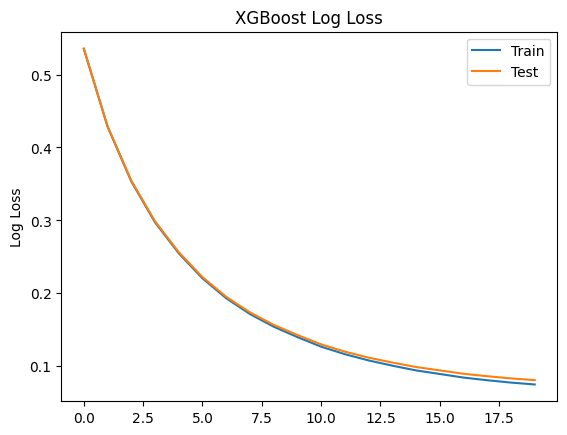

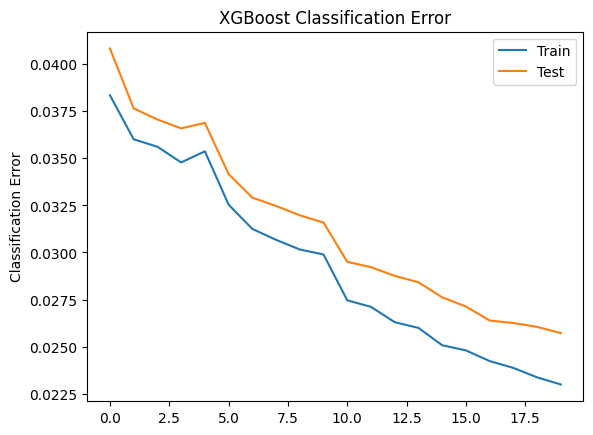

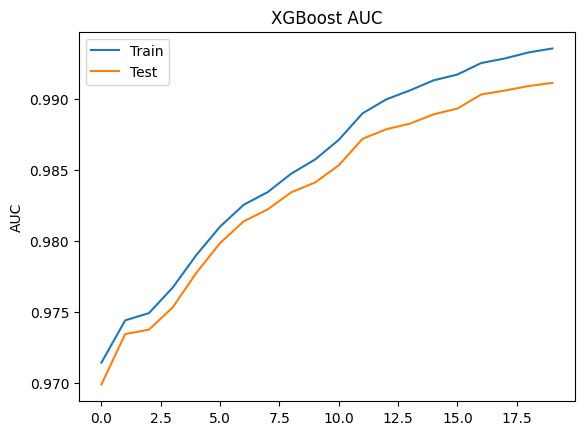

In [74]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()
# plot AUC
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

In [75]:
predicted = model.predict(X_test)

In [76]:
from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

0.8899512289342798


In [77]:
# get gain score
score = model.get_booster().get_score(importance_type='gain')
sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
sorted_score

[('client_auth_certs', 573.1481323242188),
 ('joint-iso-itu_policy_count', 368.9361572265625),
 ('CA_certs_in_chain_count', 251.68377685546875),
 ('dns_SOA_count', 132.14332580566406),
 ('tls_cipher_score', 119.78744506835938),
 ('broken_chain', 105.59774780273438),
 ('dns_TXT_count', 101.4321060180664),
 ('subdomain_length', 100.81317901611328),
 ('CA_certs_in_chain_ratio', 100.62601470947266),
 ('domain_registration_date', 98.45086669921875),
 ('has_tls', 93.18648529052734),
 ('dns_CNAME_count', 79.41454315185547),
 ('digit_count', 78.6233139038086),
 ('subdomain_count', 75.08662414550781),
 ('root_cert_validity_remaining', 69.21446228027344),
 ('tls_version_score', 58.98848342895508),
 ('dns_A_count', 56.93596267700195),
 ('expired_chain', 51.20967102050781),
 ('leaf_cert_validity_len', 48.92367172241211),
 ('dns_NS_count', 48.71366500854492),
 ('mean_certs_validity_len', 40.57467269897461),
 ('tls_chain_len', 39.237369537353516),
 ('average_rtt', 36.634490966796875),
 ('root_cert_v

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9762    0.9949    0.9854     77508
           1     0.9588    0.8303    0.8900     11098

    accuracy                         0.9743     88606
   macro avg     0.9675    0.9126    0.9377     88606
weighted avg     0.9740    0.9743    0.9735     88606



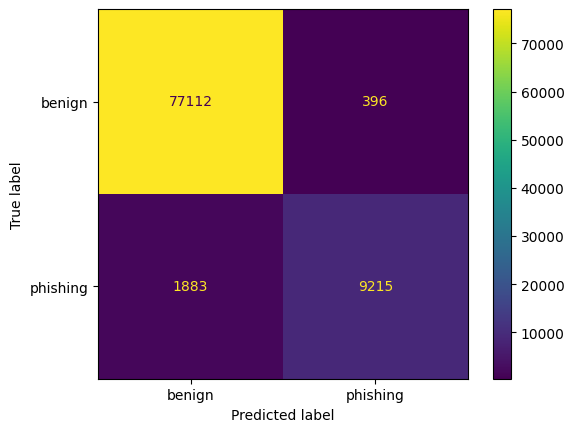

In [79]:
# confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'phishing'])
disp.plot()

In [80]:
import shap
shap.initjs()
#
X_sample = X_test[0:30000]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [89]:
import ipywidgets as widgets
from ipywidgets import interact
plot_type = widgets.RadioButtons(
    options=['dot', 'layered_violin', 'bar'],
    value='layered_violin',
    description='Plot Type:',
    disabled=False
)
max_display = widgets.IntText(
    value=10,
    description='Max Features:',
    disabled=False
)

@interact
def plot_shap(plot_type=plot_type, max_display=max_display):
    if plot_type == 'dot':
        shap.summary_plot(shap_values, X_sample, plot_type="dot", color='coolwarm', class_names=le.classes_, max_display=max_display, plot_size=0.75)
    elif plot_type == 'layered_violin':
        shap.summary_plot(shap_values, X_sample, plot_type="layered_violin", color='coolwarm', class_names=le.classes_, max_display=max_display, plot_size=0.75)
    elif plot_type == 'bar':
        shap.summary_plot(shap_values, X_sample, plot_type="bar", class_names=le.classes_, max_display=max_display, plot_size=0.75)

interactive(children=(RadioButtons(description='Plot Type:', index=1, options=('dot', 'layered_violin', 'bar')…

In [82]:
test_sample = 0
# print predicted and actual label
print('Predicted: ', le.inverse_transform([predicted[test_sample]])[0])
print('Actual: ', le.inverse_transform([y_test[test_sample]])[0])
shap.force_plot(explainer.expected_value, shap_values[test_sample,:], X_sample.iloc[test_sample,:], out_names='phishing')

Predicted:  benign:unknown
Actual:  benign:unknown


In [83]:
test_sample = y_test[0:30000].tolist().index(1, 1000)
print(le.inverse_transform(y_test[test_sample:test_sample+10]))
shap.force_plot(explainer.expected_value, shap_values[test_sample:test_sample+10,:], X_sample.iloc[test_sample:test_sample+10,:], out_names='phishing')

['misp:phishing' 'benign:unknown' 'benign:unknown' 'benign:unknown'
 'benign:unknown' 'benign:unknown' 'misp:phishing' 'benign:unknown'
 'benign:unknown' 'misp:phishing']


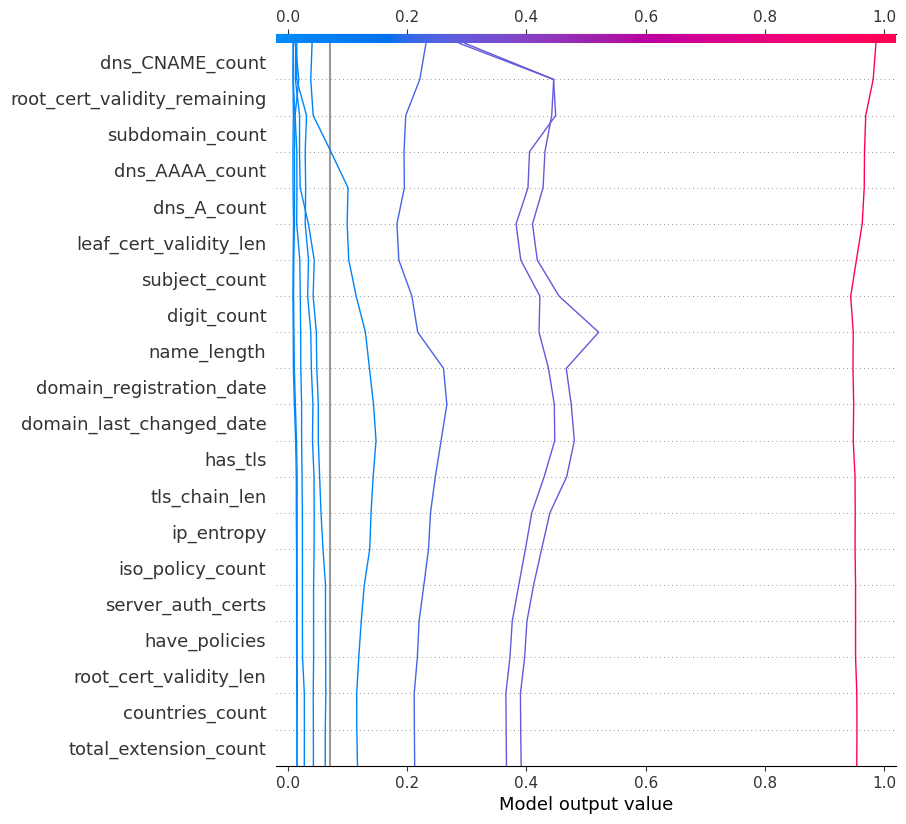

In [84]:
# show the decision plot for a range of samples from M to N
M = 0
N = 10
shap.decision_plot(explainer.expected_value, shap_values[M:N,:], X_sample.iloc[M:N,:], link='logit', feature_order='hclust', feature_names=X_sample.columns.tolist())